In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
import os

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Device Name:', torch.cuda.get_device_name(0))
print('Device Count:', torch.cuda.device_count())
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

Device: cuda
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU
Device Count: 1
System Version: 3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]
PyTorch version 2.6.0+cu126
Torchvision version 0.21.0+cu126
Numpy version 2.1.2
Pandas version 2.2.3


In [7]:
IMAGE_PATH = Path('dataset/')
IMAGE_PATH_LIST = list(IMAGE_PATH.glob('*/*'))
print(f'total images = {len(IMAGE_PATH_LIST)}')

total images = 1987


In [8]:
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 30)
print(" " * 17, "Total Images per class")
print("**" * 30)
for c in classes:
    imgs_class = len(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")))
    print(f"* {c} => {imgs_class} images")

************************************************************
                  Total Images per class
************************************************************
* glass => 501 images
* metal => 410 images
* paper => 594 images
* plastic => 482 images


In [9]:
path = [None] * len(IMAGE_PATH_LIST)
label = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    path[i] = img_path
    label[i] = img_path.parent.stem
    
df_path_label = pd.DataFrame({"path":path, 
                              "label":label})

df_path_label.head()

,path,label
0,dataset\glass\glass_001.jpg,glass
1,dataset\glass\glass_002.jpg,glass
2,dataset\glass\glass_003.jpg,glass
3,dataset\glass\glass_004.jpg,glass
4,dataset\glass\glass_005.jpg,glass


In [10]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
SEED = 123

df_train, df_rest = train_test_split(df_path_label, 
                                     test_size = 0.3, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_path_label["label"])

df_valid, df_test = train_test_split(df_rest, 
                                     test_size = 0.5, 
                                     random_state = SEED, 
                                     shuffle = True, 
                                     stratify = df_rest["label"])

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_valid)}")
print(f"Test size: {len(df_test)}")
df_train.head()

Train size: 1390
Validation size: 298
Test size: 299


,path,label
1221,dataset\paper\paper_311.jpg,paper
1369,dataset\paper\paper_459.jpg,paper
1587,dataset\plastic\plastic_083.jpg,plastic
1944,dataset\plastic\plastic_440.jpg,plastic
1512,dataset\plastic\plastic_008.jpg,plastic


In [11]:
df_test.head()

,path,label
1479,dataset\paper\paper_569.jpg,paper
1430,dataset\paper\paper_520.jpg,paper
1405,dataset\paper\paper_495.jpg,paper
470,dataset\glass\glass_471.jpg,glass
524,dataset\metal\metal_024.jpg,metal


In [12]:
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'glass': 0, 'metal': 1, 'paper': 2, 'plastic': 3}

In [38]:
df_train["label"] = df_train["label"].map(label_map)
df_valid["label"] = df_valid["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)
df_train.head()

,path,label
0,dataset\paper\paper_311.jpg,NaN
1,dataset\paper\paper_459.jpg,NaN
2,dataset\plastic\plastic_083.jpg,NaN
3,dataset\plastic\plastic_440.jpg,NaN
4,dataset\plastic\plastic_008.jpg,NaN


In [14]:
df_train = df_train.reset_index(drop = True)
df_valid = df_valid.reset_index(drop = True)

In [15]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.RandomRotation(15),  # Rotate randomly by ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [32]:
class CustomDataset:
    def __init__(self, df:pd.DataFrame, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:    
            image_path = self.df.iloc[idx, 0]
            image = Image.open(image_path).convert("RGB")
            image = self.transforms(image)
            label = self.df.iloc[idx, 1]

            return image,label
    
        except Exception as e:
            print(f"Error loading image: {image_path} -> {e}")
            return None

In [39]:
valid_dataset = CustomDataset(df_valid, valid_transforms)
train_dataset = CustomDataset(df_train, train_transforms)
test_dataset = CustomDataset(df_test, valid_transforms)

In [40]:
BATCH_SIZE = 16
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

In [19]:
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [20]:
batch_labels

tensor([0, 3, 0, 2, 0, 1, 1, 2, 0, 3, 3, 0, 0, 2, 2, 2])

In [23]:
class WasteClassifier(nn.Module):
    def __init__(self, num_classes=4, model_name="efficientnet_b0", freeze_base=False):
        super(WasteClassifier, self).__init__()
        
        # Load EfficientNet model dynamically
        self.base_model = timm.create_model(model_name, pretrained=True, num_classes=0)  # Remove head
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # Get feature extractor output size
        enet_out_size = self.base_model.num_features
        
        # Optionally freeze the base model
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False

        # Improved Classifier head with Dropout
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, 512),  # Hidden layer
            nn.ReLU(),
            nn.Dropout(0.8),  # Dropout to prevent overfitting
            nn.Linear(512, num_classes)  # Final output layer
        )

    def forward(self, x):
        x = self.features(x)  # Feature extractor
        return self.classifier(x)  # Classifier head


In [57]:
model=WasteClassifier()
model.to(device)
print(str(model)[:500])

WasteClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)



In [58]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): Number of epochs to wait after the last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, valid_loss):
        # Check if validation loss improved
        if valid_loss < self.best_loss - self.min_delta:
            self.best_loss = valid_loss
            self.counter = 0  # Reset counter if improvement
        else:
            self.counter += 1  # Increment if no improvement

        # Check if patience is exceeded
        if self.counter >= self.patience:
            self.early_stop = True

In [65]:
loss_fn = nn.CrossEntropyLoss()
# Define optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler (reduce LR by 50% every 5 epochs)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [75]:
def train_step(model=model, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader , loss_fn=loss_fn, optimizer=optimizer, device=device):
    
    
    train_losses, val_losses = [], []
    
    # Training phase
    model.train()
    running_loss_t = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        labels.pred_loit = model(images)

        # zero gradients
        optimizer.zero_grad()

        outputs = model(images)
        
        # Loss
        loss = loss_fn(outputs, labels)

        # Gradients = backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        running_loss_t += loss.item()
    train_loss = running_loss_t / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss_e = 0.0
    with torch.inference_mode():
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Loss
            loss = loss_fn(outputs, labels)

            running_loss_e += loss.item()
    val_loss = running_loss_e / len(valid_dataloader)
    val_losses.append(val_loss)
    return train_losses, val_losses, running_loss_t, running_loss_e
        

In [78]:
# Function that stores the best model with the least loss in the validation set.
def save_checkpoint(filename, model, epoch, loss, optimizer):
    state = {"filename":filename, 
             "model":model.state_dict(), 
             "epoch":epoch, 
             "loss":loss, 
             "optimizer":optimizer.state_dict()}
    print(f"Saving model to {filename} at epoch {epoch} with loss {loss}")
    torch.save(model.state_dict(), filename)

In [79]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int):
    
    results = {"train_loss":[], 
               "valid_loss":[],}
    
    best_valid_loss = float("inf")
    
    for epoch in range(epochs):
        
        train_losses, val_losses, train_loss, valid_loss= train_step(model = model, 
                                                train_dataloader = train_dataloader, 
                                                valid_dataloader = valid_dataloader,
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, 
                            model, 
                            epoch, 
                            best_valid_loss, 
                            optimizer)
            
        
        print(f"Epoch: {epoch + 1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Valid Loss: {valid_loss:.4f} | ")
        
        results["train_loss"] = train_losses
        results["valid_loss"] = val_losses

        scheduler.step()
        early_stopper = EarlyStopping(patience=5, min_delta=0.001)
        early_stopper(valid_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered. Stopping training.")
            break  # Exit training loop
        
    return results

In [80]:
import gc
EPOCHS = 20
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


gc.collect()
torch.cuda.empty_cache()


MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      valid_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)
print(MODEL_RESULTS)

Saving model to best_model.pth at epoch 0 with loss 3.6118497216375545
Epoch: 1 |  Train Loss: 13.5220 |  Valid Loss: 3.6118 | 
Saving model to best_model.pth at epoch 1 with loss 3.4150925904978067
Epoch: 2 |  Train Loss: 9.8156 |  Valid Loss: 3.4151 | 
Saving model to best_model.pth at epoch 2 with loss 3.3998781359405257
Epoch: 3 |  Train Loss: 11.1918 |  Valid Loss: 3.3999 | 
Epoch: 4 |  Train Loss: 9.2337 |  Valid Loss: 4.2433 | 
Epoch: 5 |  Train Loss: 7.4308 |  Valid Loss: 3.4962 | 
Epoch: 6 |  Train Loss: 9.3280 |  Valid Loss: 3.5627 | 
Epoch: 7 |  Train Loss: 9.1356 |  Valid Loss: 3.9877 | 
Epoch: 8 |  Train Loss: 5.7332 |  Valid Loss: 3.8664 | 
Epoch: 9 |  Train Loss: 5.9681 |  Valid Loss: 3.5014 | 
Saving model to best_model.pth at epoch 9 with loss 3.3451015971950255
Epoch: 10 |  Train Loss: 4.8157 |  Valid Loss: 3.3451 | 
Epoch: 11 |  Train Loss: 5.5593 |  Valid Loss: 3.6254 | 
Epoch: 12 |  Train Loss: 5.4786 |  Valid Loss: 3.7232 | 
Epoch: 13 |  Train Loss: 4.4712 |  Vali

In [81]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated(), torch.cuda.memory_reserved()


(152048128, 406847488)

In [24]:
# Load only model weights
state_dict = torch.load("best_model.pth", map_location=device)
# Load the best model for evaluation
best_model = WasteClassifier(num_classes=4)  # Make sure to use the same architecture
best_model.load_state_dict(state_dict)
best_model.to(device)
best_model.eval()

print("✅ Best model loaded successfully!")


✅ Best model loaded successfully!


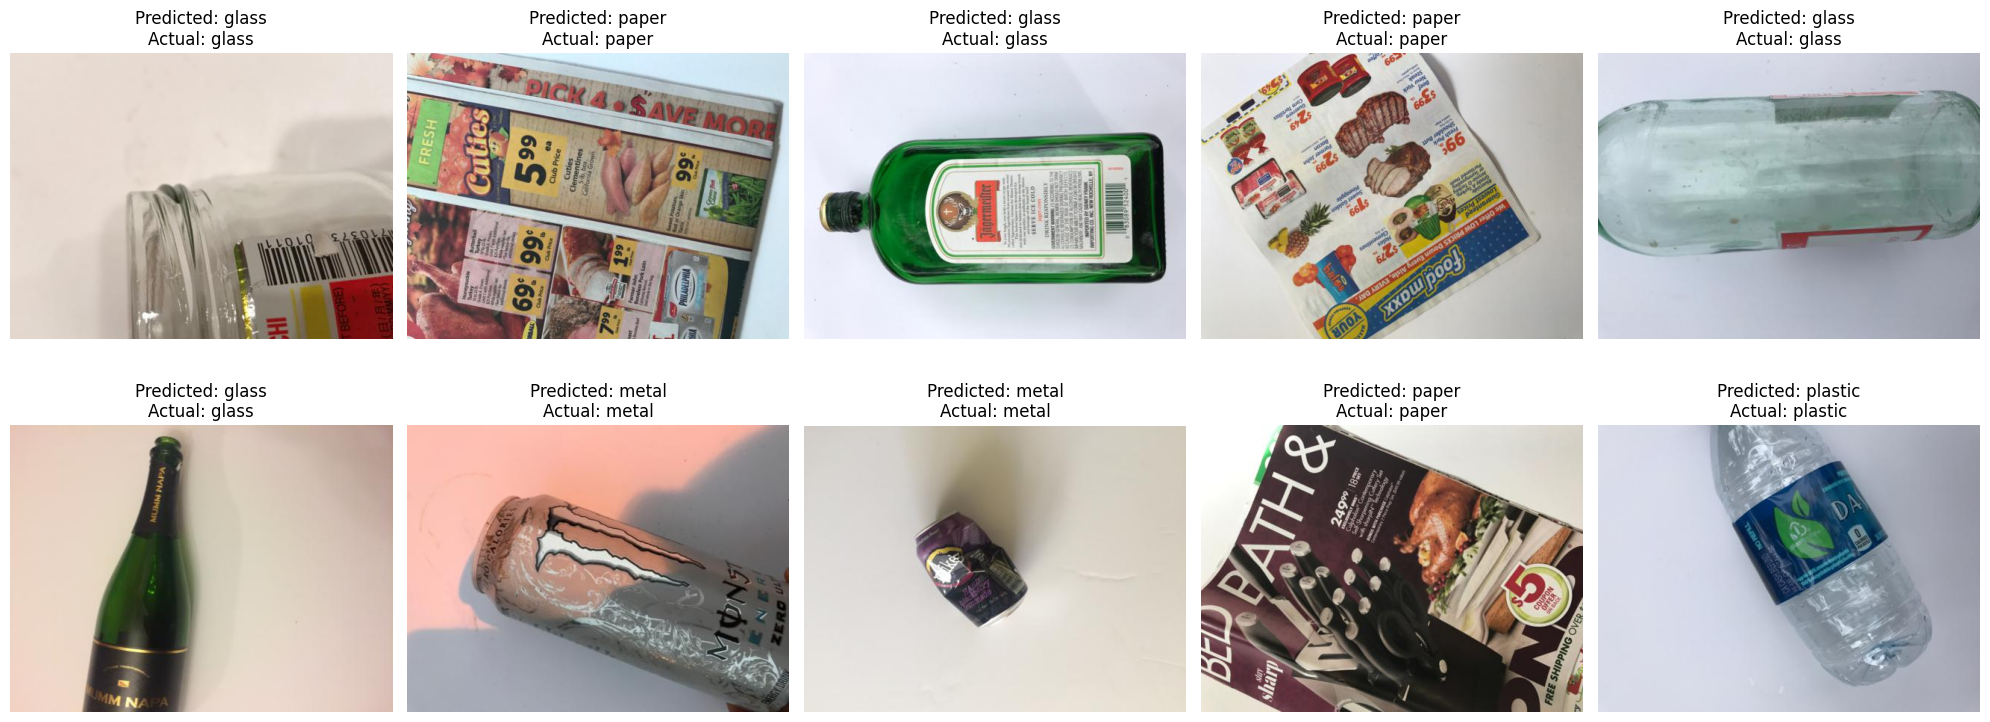

In [26]:
import random

# Select 10 random images from the test dataset
random_indices = random.sample(range(len(df_test)), 10)
random_images_paths = df_test.iloc[random_indices]['path'].values
random_images_labels = df_test.iloc[random_indices]['label'].values

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (image_path, image_label, ax) in enumerate(zip(random_images_paths, random_images_labels, axes)):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    transformed_image = valid_transforms(image).unsqueeze(0).to(device)

    # Get the model prediction
    best_model.eval()
    with torch.no_grad():
        output = best_model(transformed_image)
        _, predicted_label = torch.max(output, 1)

    # Map the predicted label back to the class name
    predicted_class = list(label_map.keys())[list(label_map.values()).index(predicted_label.item())]

    # Display the image and the prediction
    ax.imshow(image)
    ax.set_title(f'Predicted: {predicted_class}\nActual: {image_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [41]:
# Create a dataset and dataloader for the test set
test_dataset = CustomDataset(df_test, valid_transforms)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Function to evaluate the model on the test dataset
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            # Check if the batch is None
            if batch is None:
                continue  # Skip this batch

            # Unpack the batch into images and labels
            images, labels = batch

            # Ensure images and labels are tensors before moving to device
            images, labels = images.to(device), labels.to(device)
                
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate the best model on the test dataset
test_accuracy = evaluate_model(best_model, test_dataloader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 95.32%
